## Declarations

### Imports

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import math
import string
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import random
from IPython.display import display
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm

import tensorflow_hub as hub
import tensorflow_text as text

tfk = tf.keras
tfkl = tf.keras.layers
kb = tf.keras.backend
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

2.12.0
Num GPUs Available:  2


### Constants

In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

kaggle1 = "/kaggle/input/transformers-hackathon/"
kaggle2 = "/kaggle/input/transformers-hackathon-features/"

image_dir = "./resized_train"
caption_pred_file = "caption_prediction_train.csv"
concept_det_file = "concept_detection_train.csv"
concept_file = "concepts.csv"

##### Kaggle filepath #####
image_dir = kaggle1 + image_dir
caption_pred_file = kaggle2 + caption_pred_file
concept_det_file = kaggle2 + concept_det_file
concept_file = kaggle2 + concept_file
###########################

image_size = (128, 128, 3)

batch_size = 10
epochs = 100

## Preprocessing

In [3]:
feature_types = {'image': tf.float16, 'caption': tf.string, 'concepts': tf.bool, 'raw caption': tf.string, 'image path': tf.string}
feature_shapes = {'image': (128, 128, 3), 'caption': (), 'concepts': (8374)}
base_features = ["image", "caption"]

In [4]:
concepts = pd.read_csv(concept_file, sep='\t')
concept_list = concepts.set_index('concept')['concept_name'].to_dict()
# Concept one-hot encoder
concepts_onehot = MultiLabelBinarizer(classes = list(concept_list.keys()))
concepts_onehot.fit([list(concept_list.keys())])

captions = pd.read_csv(caption_pred_file, sep='\t')
captions = captions.set_index('ID')['caption'].to_dict()
captions = {id: "[SOS] " + caption + " [EOS]" for id, caption in captions.items()}

concepts = pd.read_csv(concept_det_file, sep='\t')
concepts = concepts.set_index('ID')['cuis'].to_dict()
concepts = {id: item_concepts.split(";") for id, item_concepts in concepts.items()}

In [5]:
def split(x, test_size=0.2, val_size=0.0, seed=0):
    if val_size + test_size >= 1:
        return None
    x_train, x_test = train_test_split(
        x, test_size=test_size + val_size, random_state=seed
    )
    x_val = None
    if val_size > 0:
        x_test, x_val = train_test_split(
            x_test,
            test_size=val_size / (test_size + val_size),
            random_state=seed,
        )
    return x_train, x_val, x_test

def load_image_from_path(path):
    image = tf.io.read_file(path)
    image = tf.io.decode_jpeg(image, channels=3, dct_method="INTEGER_ACCURATE")

    # may need resizing
    #image = tf.image.resize(image, image_shape[:2])
    image = tf.cast(image, dtype=tf.float16)
    image = image / 255.0
    return image

In [6]:
def custom_standardization(input_string):
    # convert input string to lowercase
    lowercase = tf.strings.lower(input_string)
    # replace special characters with empty string
    # TODO
    #return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")
    return lowercase

In [7]:
result = ""
for i in captions.values():
    result += " " + i
result = custom_standardization(result)
result = bytes.decode(result.numpy())
vocab_size = len(set(result.split()))
print("Vocab size:")
print(vocab_size)

longest = max(captions.values(), key=len)
longest = custom_standardization(longest)
longest = bytes.decode(longest.numpy())
longest = longest.split()
sequence_length = len(longest)
print("Longest sequence:")
print(sequence_length)

concept_size = max([len(c) for _, c in concepts.items()])
print("Max number of concepts:")
print(concept_size)

Vocab size:
35491
Longest sequence:
393
Max number of concepts:
50


In [8]:
def load_features(image_folder, captions_file, concepts_file, concept_encoder, filter_percent=1):
    features = []
    
    # Import CSVs
    csv_caption_dataset = tf.data.experimental.CsvDataset(
        captions_file,
        field_delim='\t',
        record_defaults=[tf.string, tf.string],
        header=True,
        select_cols=[0, 1]
    )
    csv_concept_dataset = tf.data.experimental.CsvDataset(
        concepts_file,
        field_delim='\t',
        record_defaults=[tf.string, tf.string],
        header=True,
        select_cols=[0, 1]
    )
    
    # We make the assumption that CSV files contain the same key values (image names)
    # following the same ordering

    # Extract features from dataset
    print("Extracting features from CSV file(s)")
    for caption_el, concept_el in tqdm(zip(csv_caption_dataset, csv_concept_dataset)):
        filename_cap, caption = caption_el
        filename_con , concepts = concept_el
        
        # Sanity check
        assert filename_cap == filename_con
        
        image_path = image_dir + "/" + filename_cap + ".jpg"
        
        features.append({
            'caption': caption,
            'image path': image_path,
            'concepts': concept_encoder.transform([concepts.numpy().decode("utf-8").split(";")]),
        })
        
    # Filter elements
    if filter_percent != 1:
        n_features = int(len(features) * filter_percent)
        features = random.sample(features, n_features)
        
    return features

def preprocess_features(features, concept_encoder):
    print("Preprocessing features")  
    return {
        'image paths': tf.convert_to_tensor([x["image path"] for x in tqdm(features)], dtype=tf.string),
        'captions': tf.convert_to_tensor([x["caption"] for x in tqdm(features)], dtype=tf.string),
        'concepts': tf.convert_to_tensor(np.vstack([concept_encoder.transform(x["concepts"]).flatten() for x in tqdm(features)]), dtype=tf.bool),
        'images': tf.convert_to_tensor([load_image_from_path(x["image path"]) for x in tqdm(features)], dtype=tf.float16),
    }

In [9]:
# Load dataset features from csv files, split them and preprocess them
features = load_features(image_dir, caption_pred_file, concept_det_file, concepts_onehot, filter_percent=0.05)
feat_train, feat_val, feat_test = split(features, test_size=0.2, val_size=0.0, seed=seed)

#feat_train = preprocess_features(features, concepts_onehot) if feat_train else None
#feat_val = preprocess_features(features, concepts_onehot) if feat_val else None
#feat_test = preprocess_features(features, concepts_onehot) if feat_test else None

Extracting features from CSV file(s)


83275it [01:28, 944.56it/s] 


In [10]:
def create_simple_dataset(features):
    if not features:
        return None 

    dataset = tf.data.Dataset.from_tensor_slices((features['images'], features['concepts']))
    return dataset
    
def create_dataset(
        features, 
        input_features_types,
        feature_shapes,
        x_features, y_features=None, 
        x_dict=True, y_dict=True,
        load_images=True, 
        shuffle_buffer_size=1024, 
        batch_size=32,
        batch=True,
        cached=False
):
    # Generate dataset following initial input feature types
    dataset = tf.data.Dataset.from_generator(
        lambda: features, { x: input_features_types[x] for x in input_features_types }
    )
    
    # Preprocessing internal functions
    def setshape(e):
        for (k, v) in feature_shapes.items():
            if k in e:
                e[k].set_shape(v)
        return e
    def add_images(e):
        # Maybe parametrize
        img_from = "image path"
        img_to = "image"
        new_features = list(input_features_types.keys()) + [img_to]
        return {f:e[f] if f != img_to else load_image_from_path(e[img_from]) for f in new_features}
    def split_xy(e):
        e_x = {xf:e[xf] for xf in x_features} if x_dict else tf.squeeze([e[xf] for xf in x_features])
        if y_features:
            e_y = {yf:e[yf] for yf in y_features} if y_dict else tf.squeeze([e[yf] for yf in y_features])
            return (e_x, e_y)
        return e_x
    
    # Preprocess
    if load_images:
        dataset = dataset.map(add_images)
    dataset = dataset.map(setshape)
    dataset = dataset.map(split_xy)

    # Compile dataset
    if cached:
        dataset = dataset.cache()
    dataset = dataset.shuffle(shuffle_buffer_size)
    if batch:
        dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

def visualize_first_of_dataset_batch(dataset_batch, nums=5):
    for c in range(0, nums):
        i = tf.cast(dataset_batch["image"][c], dtype=tf.float32)
        t = dataset_batch["raw caption"][c]
        plt.figure(figsize=(50, 100))
        plt.subplot(nums, 1, c + 1)
        plt.imshow(i)
        plt.title(f"{t}", fontsize=100)
        plt.xticks([])
        plt.yticks([])

In [11]:
in_feat_typ = {'caption': tf.string, 'concepts': tf.bool, 'image path': tf.string}
x_features = ['caption', 'image']
x_features_iep = ['image']
y_features_iep = ['concepts']

train_ds_size = len(feat_train) if feat_train else 0
val_ds_size = len(feat_val) if feat_val else 0
test_ds_size = len(feat_test) if feat_test else 0

In [12]:
train_dataset = create_dataset(feat_train, input_features_types=in_feat_typ, feature_shapes=feature_shapes, x_features=x_features) if feat_train else None
val_dataset = create_dataset(feat_val, input_features_types=in_feat_typ, feature_shapes=feature_shapes, x_features=x_features) if feat_val else None
test_dataset = create_dataset(feat_test, input_features_types=in_feat_typ, feature_shapes=feature_shapes, x_features=x_features) if feat_test else None

train_dataset_iep = create_dataset(feat_train, input_features_types=in_feat_typ, feature_shapes=feature_shapes, x_features=x_features_iep, y_features=y_features_iep, x_dict=False, y_dict=False, batch_size=batch_size, cached=True) if feat_train else None
val_dataset_iep = create_dataset(feat_val, input_features_types=in_feat_typ, feature_shapes=feature_shapes, x_features=x_features_iep, y_features=y_features_iep, x_dict=False, y_dict=False, batch_size=batch_size, cached=True) if feat_val else None
test_dataset_iep = create_dataset(feat_test, input_features_types=in_feat_typ, feature_shapes=feature_shapes, x_features=x_features_iep, y_features=y_features_iep, x_dict=False, y_dict=False, batch_size=batch_size, cached=True) if feat_test else None

train_dataset_eval = create_dataset(feat_train, input_features_types=in_feat_typ, feature_shapes=feature_shapes, x_features=['image path', 'image'], y_features=['caption'], x_dict=True, y_dict=True, batch_size=1, shuffle_buffer_size=1)
test_dataset_eval = create_dataset(feat_test, input_features_types=in_feat_typ, feature_shapes=feature_shapes, x_features=['image path', 'image'], y_features=['caption'], x_dict=True, y_dict=True, batch_size=1, shuffle_buffer_size=1)

## Download Models

In [13]:
text_preprocess = hub.KerasLayer(
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2",
        name="text_preprocessing",
    )

text_transformer = hub.KerasLayer(
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1",
        trainable=True,
        name="bert",
    )

img_preprocess = tfk.applications.convnext.preprocess_input

img_supernet = tfk.applications.ConvNeXtTiny(weights='imagenet', include_top=False)
supernet_name = img_supernet.name

111650432/111650432 [==============================] - 1s 0us/step


## Pre-pre-training

In [17]:
def image_encoder_pretrainer(preprocessing, supernet, n_concepts, input_shape=(128,128,3), learning_rate=1e-5):
    
    input_layer = tfkl.Input(shape=input_shape, name='image')

    x = preprocessing(input_layer)
    x = supernet(x)
    
    x = tfkl.GlobalAveragePooling2D(name='GAP')(x)
    x = tfkl.Dense(256, activation='relu')(x)
    x = tfkl.Dense(128, activation='relu')(x)
    x = tfkl.Dense(n_concepts, activation="sigmoid", name='output')(x)

    image_encoder_pretrainer = tfk.Model(inputs=input_layer, outputs=x, name="image_encoder_pretrainer")
    image_encoder_pretrainer.compile(
        loss="binary_crossentropy", optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
    )
    
    return image_encoder_pretrainer

In [23]:
iep = image_encoder_pretrainer(img_preprocess, img_supernet, len(concept_list.keys()))

In [24]:
history = iep.fit(
    train_dataset_iep,
    epochs = 5,
    validation_data = test_dataset_iep,
)

Epoch 1/5
667/667 [==============================] - 187s 144ms/step - loss: 0.2258 - val_loss: 0.0121
Epoch 2/5
667/667 [==============================] - 77s 116ms/step - loss: 0.0064 - val_loss: 0.0042
Epoch 3/5
667/667 [==============================] - 75s 112ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 4/5
667/667 [==============================] - 76s 113ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 5/5
667/667 [==============================] - 74s 111ms/step - loss: 0.0035 - val_loss: 0.0036


In [ ]:
# Create a learning rate scheduler callback.
reduce_lr = tfk.callbacks.ReduceLROnPlateau(
    monitor = "val_loss", factor = 0.2, patience = 3
)

# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss", patience = 5, restore_best_weights = True
)

iep.layers[0].trainable = True
iep.compile(
    loss="binary_crossentropy", optimizer=tf.optimizers.Adam(learning_rate=1e-6),
)

history = iep.fit(
    train_dataset_iep,
    epochs = 20,
    validation_data = test_dataset_iep,
    callbacks = [reduce_lr, early_stopping],
)

In [ ]:
img_supernet = iep.layers[0]
img_supernet.trainable = False

## Network

### Network blocks

In [14]:
def image_encoder(input_shape, latent_dim, embed_dim, seed=42, supernet=None, preprocessing=None):
    
    tf.random.set_seed(seed)

    input_layer = tfkl.Input(shape=input_shape, name='img_input_layer')

    x = preprocessing(input_layer)
    x = supernet(x)

    # Projection
    x = tfkl.GlobalAveragePooling2D(name='GAP')(x)
    x = tfkl.Dense(latent_dim, activation='relu')(x)
    x = tfkl.Dense(embed_dim, name='img_embedding_output_layer')(x)

    # Connect input and output through the Model class
    cnn_encoder = tfk.Model(inputs=input_layer, outputs=x, name='image_encoder')

    # Return the encoder
    return cnn_encoder

In [15]:
def text_encoder(latent_dim, embed_dim, preprocess, transformer, trainable=True):

    transformer.trainable = trainable
    
    input_layer = tfkl.Input(shape=(), dtype=tf.string, name="text_input")
    x = preprocess(input_layer)
    x = transformer(x)["pooled_output"]
    

    # Projection
    x = tfkl.Dense(latent_dim, activation='relu')(x)
    x = tfkl.Dense(embed_dim, name='txt_embedding_output_layer')(x)

    text_encoder = tfk.Model(inputs=input_layer, outputs=x, name="text_encoder")
    
    return text_encoder

In [16]:
class CLIP(tfk.Model):
    def __init__(self, image_encoder, text_encoder, temp=0.07, **kwargs):
        super().__init__(**kwargs)
        self.image_encoder = image_encoder
        self.text_encoder = text_encoder
        self.temp = temp
        self.loss_tracker = tfk.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def call(self, features, training=False):
        image_emb = self.image_encoder(features["image"], training=training)
        text_emb = self.text_encoder(features["caption"], training=training)
        return image_emb, text_emb

    def CLIP_loss(self, image_emb, text_emb):
        norm_image_emb = tf.math.l2_normalize(image_emb, axis=1)
        norm_text_emb = tf.math.l2_normalize(text_emb, axis=1)

        logits = tf.linalg.matmul(norm_image_emb, norm_text_emb, transpose_b=True) * tf.math.exp(self.temp)

        n = tf.shape(logits)[0]
        labels = tf.range(n)

        loss_img = tfk.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
        loss_txt = tfk.losses.sparse_categorical_crossentropy(labels, kb.transpose(logits), from_logits=True)

        return (loss_img + loss_txt) / tf.constant(2.0)

    def train_step(self, features):
        with tf.GradientTape() as tape:
            image_embeddings, caption_embeddings = self(features, training=True)
            loss = self.CLIP_loss(caption_embeddings, image_embeddings)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, features):
        image_embeddings, caption_embeddings = self(features, training=False)
        loss = self.CLIP_loss(caption_embeddings, image_embeddings)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}


### Building network

In [17]:
def build_clip(img_input_shape=(128,128,3),
               txt_input_shape=(393, ), 
               latent_dim=1024, 
               embed_dim=128, 
               temp=0.07,
               learning_rate=1e-5,
               img_supernet=None,
               img_preprocess=None,
               text_transformer=None,
               text_preprocess=None):

    
    text_encoder_model = text_encoder(latent_dim, embed_dim, text_preprocess, text_transformer)
    image_encoder_model = image_encoder(img_input_shape, latent_dim, embed_dim, supernet=img_supernet, preprocessing=img_preprocess)

    clip = CLIP(image_encoder_model, text_encoder_model, temp)
    clip.compile(optimizer = tf.optimizers.Adam(learning_rate=learning_rate))

    return image_encoder_model, text_encoder_model, clip

In [18]:
clip_image_encoder, clip_text_encoder, clip = build_clip(
    img_supernet=img_supernet,
    img_preprocess=img_preprocess,
    text_transformer=text_transformer,
    text_preprocess=text_preprocess,
)

## Training

### CLIP pre-training

In [19]:
# Create a learning rate scheduler callback.
reduce_lr = tfk.callbacks.ReduceLROnPlateau(
    monitor = "val_loss", factor = 0.2, patience = 3
)

# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss", patience = 5, restore_best_weights = True
)

history = clip.fit(
    train_dataset,
    epochs = epochs,
    validation_data = test_dataset,
    callbacks = [reduce_lr, early_stopping],
)

Epoch 1/100
105/105 [==============================] - 144s 686ms/step - loss: 3.4122 - val_loss: 3.2860 - lr: 1.0000e-05
Epoch 2/100
105/105 [==============================] - 55s 518ms/step - loss: 3.2419 - val_loss: 3.1914 - lr: 1.0000e-05
Epoch 3/100
105/105 [==============================] - 55s 512ms/step - loss: 3.1511 - val_loss: 3.1514 - lr: 1.0000e-05
Epoch 4/100
105/105 [==============================] - 54s 506ms/step - loss: 3.0990 - val_loss: 3.1257 - lr: 1.0000e-05
Epoch 5/100
105/105 [==============================] - 54s 502ms/step - loss: 3.0565 - val_loss: 3.1166 - lr: 1.0000e-05
Epoch 6/100
105/105 [==============================] - 54s 509ms/step - loss: 3.0167 - val_loss: 3.1021 - lr: 1.0000e-05
Epoch 7/100
105/105 [==============================] - 54s 503ms/step - loss: 2.9823 - val_loss: 3.0869 - lr: 1.0000e-05
Epoch 8/100
105/105 [==============================] - 54s 503ms/step - loss: 2.9604 - val_loss: 3.0792 - lr: 1.0000e-05
Epoch 9/100
105/105 [==========

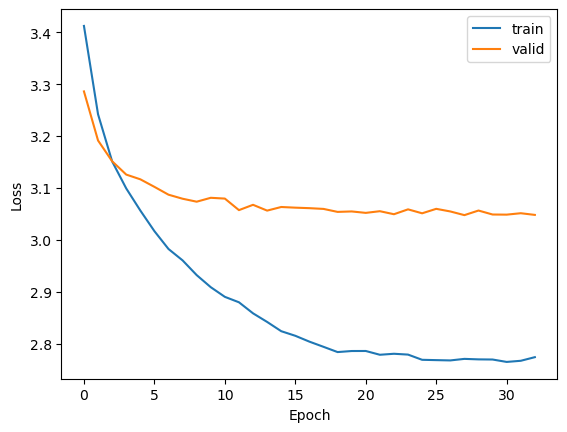

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train", "valid"], loc="upper right")
plt.show()

In [ ]:
clip.save("keras_clip_model")

### Task performance

In [21]:
def generate_image_embeddings(
    image_encoder,                 # Image encoder of clip model
    dataset_eval,                  # Dataset to generate embeddings (WARNING: the dataset must not be shuffling or have a shuffle buffer size of 1)
    dataset_pred_map=lambda *x: x, # Lambda mapping function for prediction
    dataset_ref_map=lambda *x: x,  # Lambda mapping function for reference
):
    print("Generating image embeddings")
    image_embeddings = image_encoder.predict(
        dataset_eval.map(dataset_pred_map),
        verbose=1,
    )
    dataset_reference = [x for x in train_dataset_eval.map(dataset_ref_map).unbatch()]
    return dataset_reference, image_embeddings

def find_t2i_matches(
    queries,               # Queries to search
    text_encoder,          # Text encoder of clip model
    image_embeddings,      # Generated image embeddings
    dataset_reference,     # Reference for retreived dataset elements following indices
    k=5,                   # Number of elements for top-k
    normalize=True         # Embedding normalization
):
    print("Computing Text-to-Image matches")
    # Generate query dataset and get their embeddings
    queries_ds = tf.data.Dataset.from_tensor_slices(queries).batch(batch_size)
    query_embedding = text_encoder.predict(queries_ds)
    # Normalize the query and the image embeddings
    if normalize:
        image_embeddings = tf.math.l2_normalize(image_embeddings, axis=1)
        query_embedding = tf.math.l2_normalize(query_embedding, axis=1)
    # Compute the dot product between the query and the image embeddings
    dot_similarity = tf.matmul(query_embedding, image_embeddings, transpose_b=True)
    # Retrieve top k indices
    results = tf.math.top_k(dot_similarity, k).indices.numpy()
    # Return matching image paths
    return [[dataset_reference[match] for match in result] for result in results]

def visualize_t2i_results(matches):
    # Assuming matches are in the form of tuples: (image_path, caption)
    print("Top matches for query: \"" + query + "\"")
    plt.figure(figsize=(18, 18))
    for i in range(len(matches)):
        path = matches[i][0].numpy().decode('UTF-8')
        caption = matches[i][1].numpy().decode('UTF-8')
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(mpimg.imread(path))
        plt.axis("off")
        print(f"{i}) {caption}")

Generating image embeddings
665/665 [==============================] - 18s 27ms/step
Computing Text-to-Image matches
1/1 [==============================] - 0s 16ms/step
Top matches for query: "active pheochromocytoma"
0) initial coronal ct show normal appearance of bowel and liver metastasis
1) axial compute tomography show a rounded heterogeneous mass in the right ethmoid sinus extend through the lamina papyracea into the orbit
2) coronal mri of the pelvis  image there be two small rounded lesion arrow on the sacrum adjacent to the right si joint with the same signal as those see in image
3) ra collapse sign
4) ct show a subcapsular hematoma in the right hepatic lobe the capsule be intact


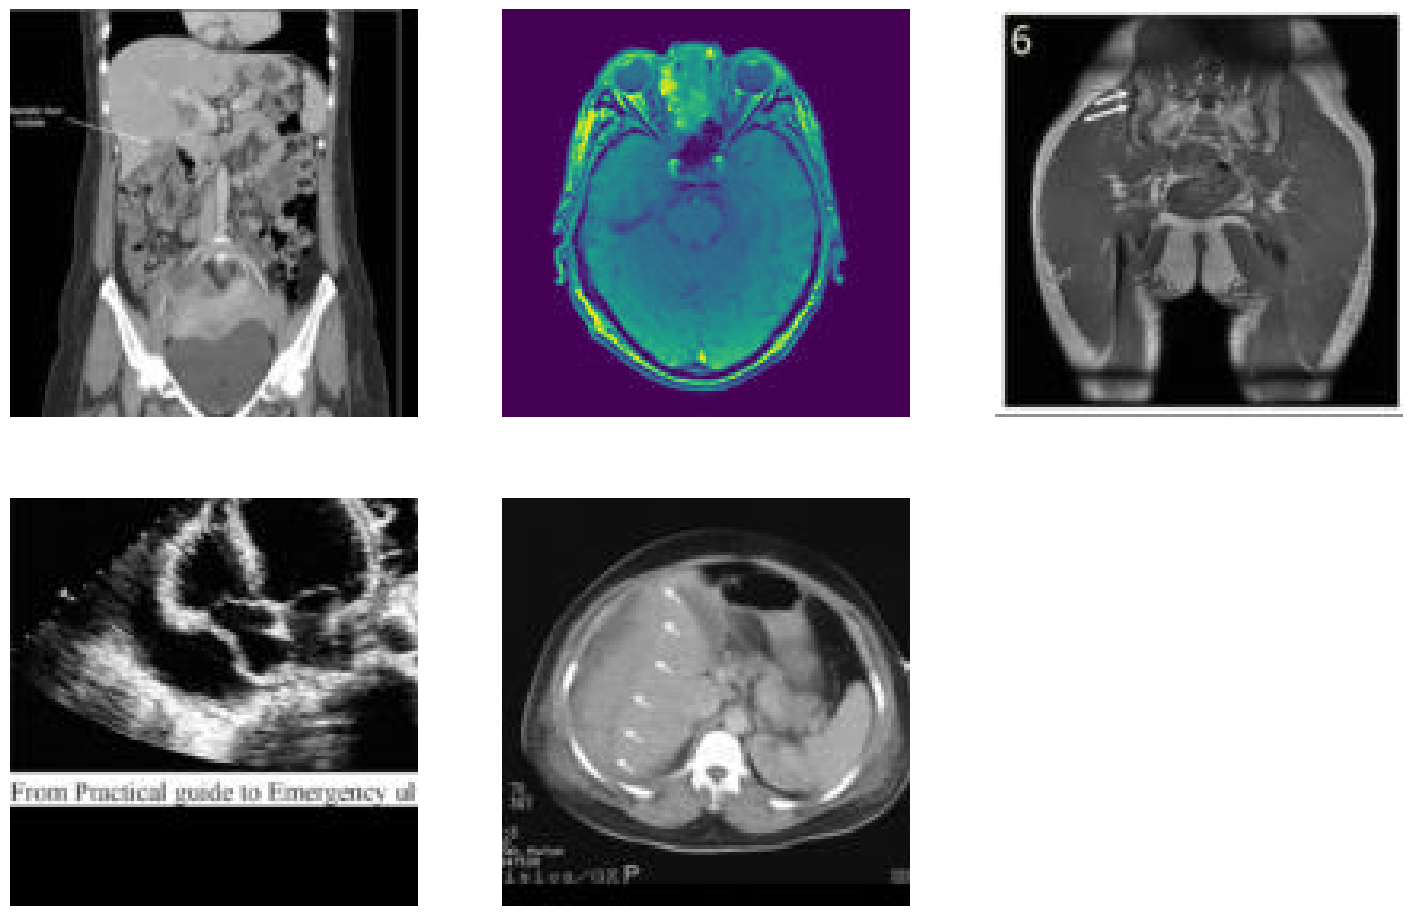

In [87]:
query = "active pheochromocytoma"
# WARNING: currently using train_dataset_eval
dataset_reference, image_embeddings = generate_image_embeddings(
    clip_image_encoder,
    train_dataset_eval,
    dataset_pred_map=lambda x, y: x['image'],
    dataset_ref_map=lambda x, y: (x['image path'], y['caption'])
)
results = find_t2i_matches([query], clip_text_encoder, image_embeddings, dataset_reference, k=5, normalize=True)
for matches in results:
    visualize_t2i_results(matches)

### Evaluation

In [22]:
def compute_top_k_accuracy(results, dataset_reference, reference_preprocess=lambda x: x):
    hits = sum([1 if reference_preprocess(original) in matches else 0 for matches, original in zip(results, dataset_reference)])
    return hits / len(dataset_reference)

In [25]:
print("Scoring training data...")
dataset_reference, image_embeddings = generate_image_embeddings(
    clip_image_encoder,
    train_dataset_eval,
    dataset_pred_map=lambda x, y: x['image'],
    dataset_ref_map=lambda x, y: y['caption']
)
results = find_t2i_matches(dataset_reference, clip_text_encoder, image_embeddings, dataset_reference, k=5, normalize=True)
train_accuracy = compute_top_k_accuracy(results, dataset_reference, reference_preprocess=lambda x: x.numpy().decode('UTF-8'))
print(f"Train accuracy: {round(train_accuracy * 100, 3)}%")

print("Scoring test data...")
dataset_reference, image_embeddings = generate_image_embeddings(
    clip_image_encoder,
    test_dataset_eval,
    dataset_pred_map=lambda x, y: x['image'],
    dataset_ref_map=lambda x, y: y['caption']
)
results = find_t2i_matches(dataset_reference, clip_text_encoder, image_embeddings, dataset_reference, k=5, normalize=True)
test_accuracy = compute_top_k_accuracy(results, dataset_reference, reference_preprocess=lambda x: x.numpy().decode('UTF-8'))
print(f"Eval accuracy: {round(test_accuracy * 100, 3)}%")

Scoring training data...
Generating image embeddings
3330/3330 [==============================] - 88s 26ms/step
Computing Text-to-Image matches
333/333 [==============================] - 9s 27ms/step
Train accuracy: 1.892%
Scoring test data...
Generating image embeddings
833/833 [==============================] - 21s 26ms/step
Computing Text-to-Image matches
333/333 [==============================] - 10s 29ms/step
Eval accuracy: 0.18%
